# Supervised classification with DeapLearning

### Importin the libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from helpers import undersampling
from configparser import ConfigParser

In [2]:
config = ConfigParser()
config.read('config.ini')
x_size = int(config['main']['x_size'])
y_size = int(config['main']['y_size'])
clases_names = list(config['classes'].values())
nr_of_classes = len(clases_names)
csv_data_file = config['main']['csv_data_file']

### Preprocessing

In [3]:
df_unchange = pd.read_csv(csv_data_file)
#df = undersampling(df_unchange,clases_names)
df = df_unchange
X = df.iloc[:,:-nr_of_classes].to_numpy()
Y = df.iloc[:,-nr_of_classes:].to_numpy()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

Feature scaling
$$x = \frac{\overline{x} - x}{\sigma_{x}}$$

In [5]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [6]:
#X = X.reshape((x_size, y_size, 14))
#Y = Y.reshape((x_size,y_size, 4))

In [7]:
X_train.shape

(393750, 10)

### Model definition

In [8]:
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training

In [10]:
model.fit(X_train, y_train, epochs=100, batch_size=10000)

Epoch 1/100
40/40 [==============================] - 0s 4ms/step - loss: 0.4141 - accuracy: 0.6010
Epoch 2/100
40/40 [==============================] - 0s 4ms/step - loss: 0.3244 - accuracy: 0.7049
Epoch 3/100
40/40 [==============================] - 0s 3ms/step - loss: 0.3100 - accuracy: 0.7214
Epoch 4/100
40/40 [==============================] - 0s 3ms/step - loss: 0.3013 - accuracy: 0.7320
Epoch 5/100
40/40 [==============================] - 0s 4ms/step - loss: 0.2945 - accuracy: 0.7410
Epoch 6/100
40/40 [==============================] - 0s 4ms/step - loss: 0.2896 - accuracy: 0.7487
Epoch 7/100
40/40 [==============================] - 0s 3ms/step - loss: 0.2855 - accuracy: 0.7546
Epoch 8/100
40/40 [==============================] - 0s 4ms/step - loss: 0.2826 - accuracy: 0.7583
Epoch 9/100
40/40 [==============================] - 0s 3ms/step - loss: 0.2798 - accuracy: 0.7610
Epoch 10/100
40/40 [==============================] - 0s 3ms/step - loss: 0.2781 - accuracy: 0.7631
Epoch 11/

### Validation

In [11]:
_, accuracy = model.evaluate(X_test, y_test)
print(f'acc: {accuracy}')

5274/5274 [==============================] - 6s 1ms/step - loss: 0.2317 - accuracy: 0.7968
acc: 0.7968000173568726


### Predictions

In [12]:
y_pred = model.predict(X_test)

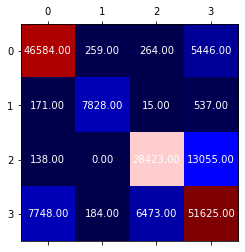

In [13]:
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
fig, ax = plt.subplots()
ax.matshow(cm, cmap='seismic')
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',color = 'white')
plt.show()

### Results Presentation

In [14]:
X_present = df_unchange.iloc[:,:-nr_of_classes].to_numpy()
X_present = sc.fit_transform(X_present)
Y_present = model.predict(X_present)
Y_present = np.rint(Y_present)
Y_present = Y_present.reshape((x_size,y_size,4))

In [15]:
Y_present.shape

(750, 750, 4)

In [16]:
Y_target = df_unchange.iloc[:,-nr_of_classes:].to_numpy()
Y_target = Y_target.reshape((x_size,y_size,nr_of_classes))

In [17]:
def show_target_pred_dif(yt,yp):
    column = ['Target','Predicted','Target - Predicted']
    nrows = yt.shape[-1]
    fig, axs = plt.subplots(figsize=(12,nrows*4), ncols = 3, nrows=nrows)
    [axi.set_axis_off() for axi in axs.ravel()]
    fig.tight_layout()
    for i in range(nrows):
        axs[i,0].imshow(yt[...,i]*255,cmap='gray', vmin=0, vmax=255)
        axs[i,1].imshow(yp[...,i]*255,cmap='gray', vmin=0, vmax=255)
        axs[i,2].imshow((yt[...,i]-yp[...,i]+1)*127,cmap='seismic', vmin=0, vmax=255)
    for ax, col in zip(axs[0], column):
        ax.set_title(col)

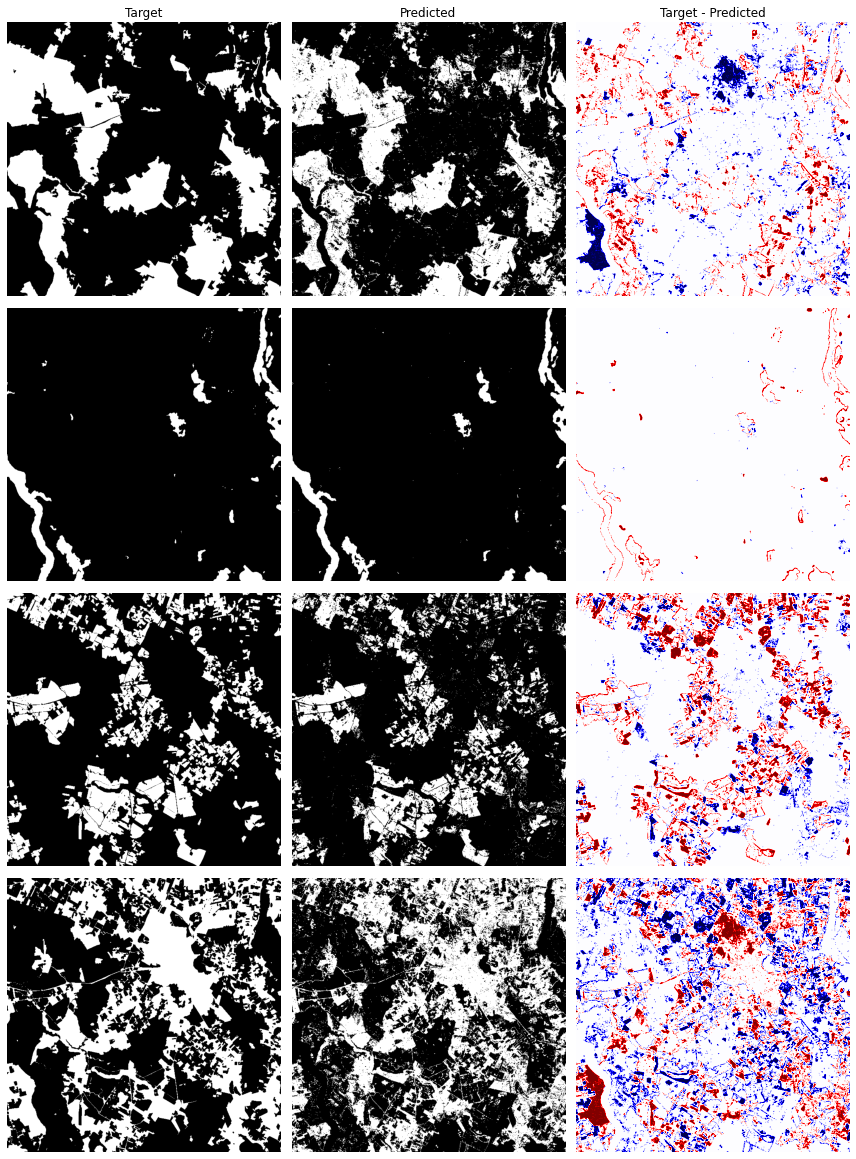

In [18]:
show_target_pred_dif(Y_target, Y_present)